<a href="https://colab.research.google.com/github/sauvatu/HS-algorithm/blob/master/Chap6_RNN_With_Added_Gates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of LSTM Class and Foward Propagation

In [8]:
import numpy as np

class LSTM:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev, c_prev):
    Wx, Wh, b = self.params
    N, H = h_prev.shape
    A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b

  # slice
    f = A[:, :H]
    g = A[:, H:2*H]
    i = A[:, 2*H:3*H]
    o = A[:, 3*H:]

    f = sigmoid(f)
    g = np.tanh(g)
    i = sigmoid(i)
    o = sigmoid(o)
    c_next = f * c_prev + g * i
    h_next = o * np.tanh(c_next)

    self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
    return h_next, c_next

Implementation of Time LSTM.
Similar with Time RNN Layer

In [10]:
class TimeLSTM:
  def __init__(self, Wx, Wh, b, stateful = False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.lavers = None
    self.h, self.c = None, None
    self.dh = None
    self.stateful = stateful

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    H = Wh.shape[0]

    self.layers = []
    hs = np.empty((N, T, H), dtype='f')

    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')
    if not self.stateful or self.c is None:
      self.c = np.zeros((N, H), dtype='f')

      for t in range(T):
        layer = LSTM(*self.params)
        self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
        hs[:, t,:]= self.h
        self.layers.append(layer)
      return hs

  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D = Wx.shape[0]

    dxs = np.empty((N, T, D), dtype='f')
    dh, dc = 0, 0
    grads = [0, 0, 0]

    for t in reversed (range(T)):
      layer = self.layers[t]
      dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
      dxs[:, t,:] = dx

    for i, grad in enumerate(layer.grads):
      grads[i] += grad

    for i, grad in enumerate(grads):
      self.grads[i][...] = grad

    self.dh = dh
    return dxs

  def set_state(self, h, c=None):
    self.h, self.c = h, c
  def reset_state(self):
    self.h, self.c = None, None

Language Model Using LSTM

In [13]:
import sys
sys.path.append('..')
from common.time_layers import *
import pickle
import numpy as np


class Rnnlm:
  def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

#weight initialization
    embed_W = (rn (V, D) / 100).astype('f')
    lstm_Wx = (rn(D, 4 * H)/np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4 * H)/np.sqrt(H)).astype('f')
    lstm_b = np.zeros(4 * H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

#Create a hierarchy
    self.layers = [
        TimeEmbedding(embed_W),
        TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
        TimeAffine(affine_W, affine_b)
     ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.lstm_layer = self.layers[1]

# Collect all weights and gradients in a list.
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def predict(self, xs):
    for layer in self.layers:
        xs = layer.forward(xs)
    return xs

  def forward(self, xs, ts):
    score = self.predict(xs)
    loss = self.loss_layer.forward(score, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    self.lstm_layer.reset_state()

  def save_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'wb') as f:
        pickle.dump(self.params, f)

  def load_params(self, file_name='Rnnlm.pkl'):
    with open(file_name, 'rb') as f:
        self.params = pickle.load(f)

Training Code of RNNLM

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.70
| 에폭 1 |  반복 21 / 1327 | 시간 4[s] | 퍼플렉서티 3115.08
| 에폭 1 |  반복 41 / 1327 | 시간 7[s] | 퍼플렉서티 1310.55
| 에폭 1 |  반복 61 / 1327 | 시간 12[s] | 퍼플렉서티 995.41
| 에폭 1 |  반복 81 / 1327 | 시간 15[s] | 퍼플렉서티 801.07
| 에폭 1 |  반복 101 / 1327 | 시간 19[s] | 퍼플렉서티 639.15
| 에폭 1 |  반복 121 / 1327 | 시간 23[s] | 퍼플렉서티 678.94
| 에폭 1 |  반복 141 / 1327 | 시간 27[s] | 퍼플렉서티 613.77
| 에폭 1 |  반복 161 / 1327 | 시간 30[s] | 퍼플렉서티 583.57
| 에폭 1 |  반복 181 / 1327 | 시간 34[s] | 퍼플렉서티 586.77
| 에폭 1 |  반복 201 / 1327 | 시간 38[s] | 퍼플렉서티 506.57
| 에폭 1 |  반복 221 / 1327 | 시간 42[s] | 퍼플렉서티 495.28
| 에폭 1 |  반복 241 / 1327 | 시간 46[s] | 퍼플렉서티 446.01
| 에폭 1 |  반복 261 / 1327 | 시간 50[s] | 퍼플렉서티 460.46
| 에폭 1 |  반복 281 / 1327 | 시간 54[s] | 퍼플렉서티 447.46
| 에폭 1 |  반복 301 / 1327 | 시간 57[s] | 퍼플렉서티 391.91
| 에폭 1 |  반복 321 / 1327 | 시간 62[s] | 퍼플렉서티 344.73
| 에폭 1 |  반복 341 / 1327 | 시간 65[s] | 퍼플렉서티 398.64
| 에폭 1 |  반복 361 / 1327 | 시간 69[s] | 퍼플렉서티 406.44
| 에폭 1 |  반복 381 / 1327 | 시간 73[s] | 퍼플렉서티 327.91
| 에폭 1

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54140 (\N{HANGUL SYLLABLE PEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47113 (\N{HANGUL SYLLABLE REG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

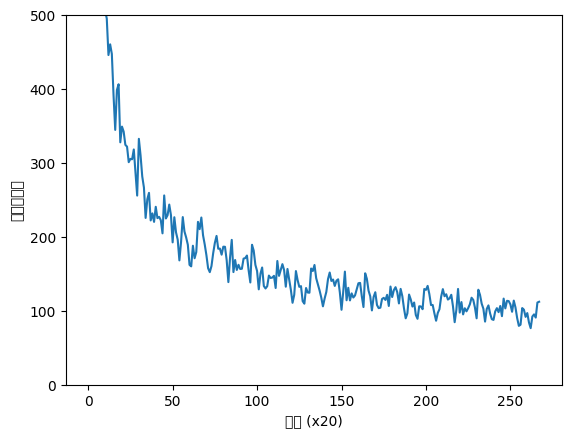

퍼플렉서티 평가 중 ...
234 / 235
test perplexity:  134.60987009552613


In [14]:
# coding: utf-8
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm


#Setting hyperparameters
batch_size = 20
wordvec_size = 100
hidden_size = 100  #Number of elements in hidden state vector of RNN
time_size = 35  #Size to expand RNN
lr = 20.0
max_epoch = 4
max_grad = 0.25

#Load training data
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

#Generating the model
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

#Learn by applying gradient clipping
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

#Evaluation using test data
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

#Saving parameters
model.save_params()

# **6.5 Further Improvements of RNNLM**

6.5.4 Implementation of Improved RNNLM (Better RNNLM)




In [15]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     A model that uses two LSTM layers and uses Dropout for each layer.
     [1]Based on the model proposed in [2][3]

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

Purplexity is Significantly Improved

In [19]:
# coding: utf-8
import sys
sys.path.append('..')
from common import config
# When running on GPU, delete the comment out below (cupy required)
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


#Setting hyperparameters
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

#Load training data
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


#Evaluation using test data
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

| 에폭 1 |  반복 1 / 1327 | 시간 2[s] | 퍼플렉서티 9999.95
| 에폭 1 |  반복 21 / 1327 | 시간 40[s] | 퍼플렉서티 3558.89


KeyboardInterrupt: 